In [1]:
import pandas as pd

# row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

In [7]:
import warnings
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# 경고 무시
warnings.filterwarnings("ignore")

# 폰트 설정
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

data = pd.read_csv('data/final_merged_update_store_age_df.csv')

# 새로운 피처 추가
data['편의점_밀도'] = data['유사_업종_점포_수']/data['영역_면적']

# 불필요한 컬럼 제거
data = data.drop(columns=['영역_면적', '상권_코드', '자치구_코드', '행정동_코드', '자치구_코드_명', '평일_유동인구_수_평균', '주말_유동인구_수_평균', '소득_구간_코드', '점포_수', '개업_율', '폐업_률', '프랜차이즈_점포_수'])

# 범주형 변수와 숫자형 변수 구분
cat_cols = ['기준_분기', '시간대', '상권_구분_코드_명', '상권_코드_명', '행정동_코드_명']
num_cols = data.columns.difference(cat_cols).tolist()


# 독립변수와 종속변수 분리
y = data.pop('시간대_매출금액')
X = data

# 독립변수 데이터 스케일링
# 변수 구분 코드에서 종속변수 제거
num_cols.remove('시간대_매출금액')

## 범주형 변수 더미화
X = pd.get_dummies(X, columns=cat_cols)

## 더미 변수화된 값이 불리언 형태로 나왔다면 0과 1로 변환
X.replace({True: 1, False: 0}, inplace=True)

## 숫자형 변수 정규화
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])


# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

def clean_feature_names(X):
    # 특수 문자를 제거하고 언더스코어(_)로 대체합니다.
    X.columns = [re.sub(r'\W+', '_', col) for col in X.columns]
    return X

# 데이터프레임 X의 특성 이름을 정제합니다.
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

# Box-Cox 변환 적용
y_train_boxcox, lambda_ = boxcox(y_train + 1)  # +1을 더하는 이유는 음수 값이 없도록 하기 위함
y_test_boxcox = boxcox(y_test + 1, lmbda=lambda_)

# 모델 학습 - LightGBM
lgbm_regression = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 범위 설정
param_grid = {
    'num_leaves': [25, 30, 35],
    'learning_rate': [0.12, 0.13, 0.14],
    'n_estimators': [375, 400, 425]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=lgbm_regression, param_grid=param_grid, cv=3)

# 모델 학습
grid_search.fit(X_train, y_train_boxcox)

# 최적의 모델로 예측 수행
best_lgbm_regression = grid_search.best_estimator_
y_pred_lgbm_grid_boxcox = best_lgbm_regression.predict(X_test)


# 예측 결과를 원래의 스케일로 되돌리기 위해 역 Box-Cox 변환 적용
y_pred_lgbm_grid = inv_boxcox(y_pred_lgbm_grid_boxcox, lambda_)

# 평가
def evaluate(y_true, y_pred):
    # MSE 계산
    mse = mean_squared_error(y_true, y_pred)
    
    # MAE 계산
    mae = mean_absolute_error(y_true, y_pred)
    
    # R-squared 계산
    r_squared = r2_score(y_true, y_pred)
    
    # RMSE 계산
    rmse = np.sqrt(mse)
    
    return {
        'MSE': mse,
        'MAE': mae,
        'R-squared': r_squared,
        'RMSE': rmse
    }


evaluate(y_test, y_pred_lgbm_grid)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2197
[LightGBM] [Info] Number of data points in the train set: 1834, number of used features: 116
[LightGBM] [Info] Start training from score 119.369792
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2199
[LightGBM] [Info] Number of data points in the train set: 1834, number of used features: 116
[LightGBM] [Info] Start training from score 119.076340
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

{'MSE': 1990717332963793.5,
 'MAE': 26312258.00076704,
 'R-squared': 0.9893749687174418,
 'RMSE': 44617455.473881446}

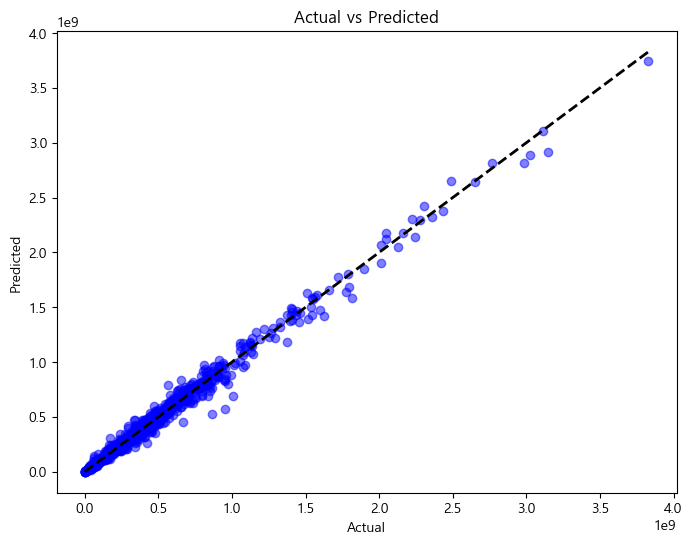

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lgbm_grid, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

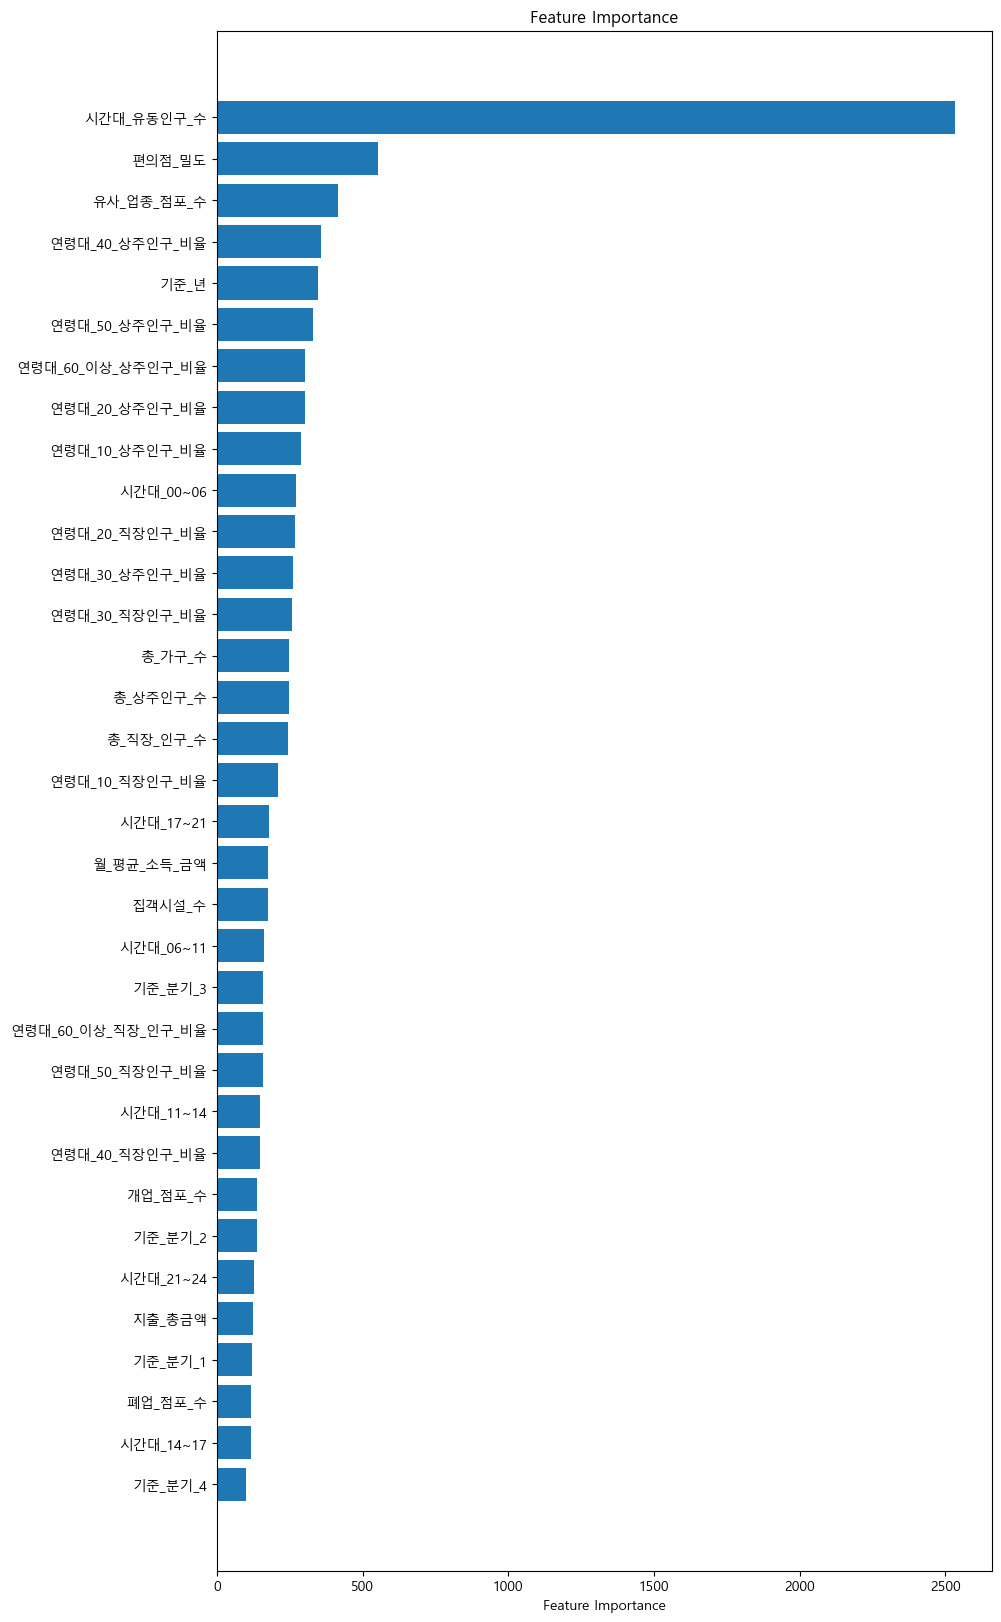

In [9]:
# 모델에서 피처 중요도 추출
feature_importance = best_lgbm_regression.feature_importances_

# 피처 중요도와 이름 추출
filtered_feature_importance = feature_importance[~X.columns.str.startswith(('상권_코드_명', '상권_구분_코드', '행정동'))]
filtered_feature_names = X.columns[~X.columns.str.startswith(('상권_코드_명', '상권_구분_코드', '행정동'))]

# 중요도가 높은 순으로 피처를 정렬
sorted_idx = np.argsort(filtered_feature_importance)[::-1]

# 피처 중요도 시각화
plt.figure(figsize=(10, 20))
plt.barh(range(len(filtered_feature_importance)), filtered_feature_importance[sorted_idx], align='center')
plt.yticks(range(len(filtered_feature_importance)), filtered_feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # 상위 피처가 상단에 오도록 역순으로 설정
plt.show()

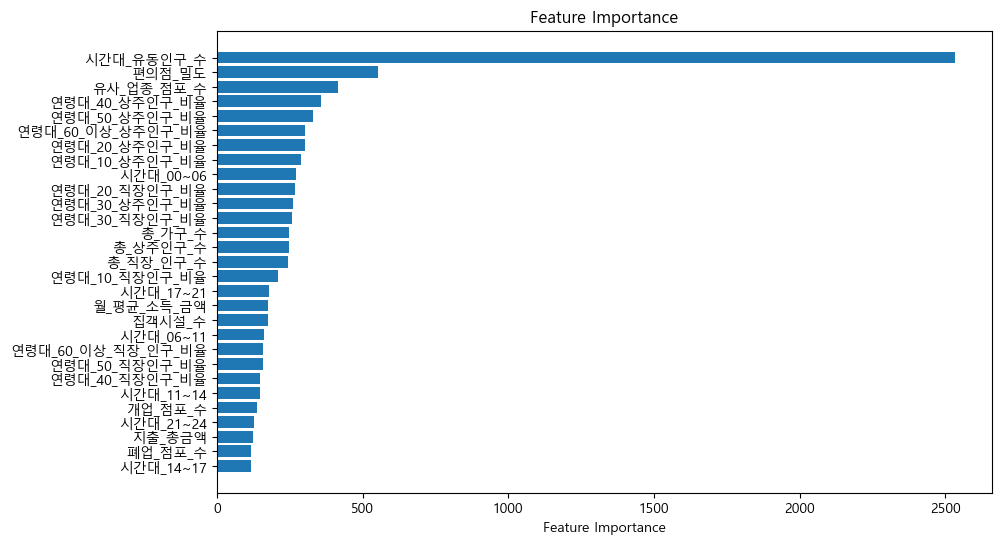

In [16]:
# 모델에서 피처 중요도 추출
feature_importance = best_lgbm_regression.feature_importances_

# 피처 중요도와 이름 추출
filtered_feature_importance = feature_importance[~X.columns.str.startswith(('상권_코드_명', '상권_구분_코드', '행정동', '기준'))]
filtered_feature_names = X.columns[~X.columns.str.startswith(('상권_코드_명', '상권_구분_코드', '행정동', '기준'))]

# 중요도가 높은 순으로 피처를 정렬
sorted_idx = np.argsort(filtered_feature_importance)[::-1]

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(filtered_feature_importance)), filtered_feature_importance[sorted_idx], align='center')
plt.yticks(range(len(filtered_feature_importance)), filtered_feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # 상위 피처가 상단에 오도록 역순으로 설정
plt.show()


In [11]:
list(X_train.columns)

['기준_년',
 '시간대_유동인구_수',
 '총_직장_인구_수',
 '연령대_10_직장인구_비율',
 '연령대_20_직장인구_비율',
 '연령대_30_직장인구_비율',
 '연령대_40_직장인구_비율',
 '연령대_50_직장인구_비율',
 '연령대_60_이상_직장_인구_비율',
 '총_상주인구_수',
 '연령대_10_상주인구_비율',
 '연령대_20_상주인구_비율',
 '연령대_30_상주인구_비율',
 '연령대_40_상주인구_비율',
 '연령대_50_상주인구_비율',
 '연령대_60_이상_상주인구_비율',
 '총_가구_수',
 '집객시설_수',
 '월_평균_소득_금액',
 '지출_총금액',
 '유사_업종_점포_수',
 '개업_점포_수',
 '폐업_점포_수',
 '편의점_밀도',
 '기준_분기_1',
 '기준_분기_2',
 '기준_분기_3',
 '기준_분기_4',
 '시간대_00_06',
 '시간대_06_11',
 '시간대_11_14',
 '시간대_14_17',
 '시간대_17_21',
 '시간대_21_24',
 '상권_구분_코드_명_골목상권',
 '상권_구분_코드_명_관광특구',
 '상권_구분_코드_명_발달상권',
 '상권_구분_코드_명_전통시장',
 '상권_코드_명_가로수길',
 '상권_코드_명_강남_마이스_관광특구',
 '상권_코드_명_강남개포시장',
 '상권_코드_명_강남구청_청담역_8번_강남세무서_',
 '상권_코드_명_강남구청역',
 '상권_코드_명_강남세브란스병원미래의학연구센터',
 '상권_코드_명_강남을지병원',
 '상권_코드_명_개나리아파트',
 '상권_코드_명_개포고등학교',
 '상권_코드_명_경기고교사거리_경기고교앞사거리_',
 '상권_코드_명_경복아파트교차로',
 '상권_코드_명_구역삼세무서',
 '상권_코드_명_국악고교사거리',
 '상권_코드_명_논현로18길',
 '상권_코드_명_논현목련공원',
 '상권_코드_명_논현역',
 '상권_코드_명_논현초등학교',
 '상권_코드_명_대청초등학교',
 '상권_코드_명_대치동아우편취급국',
 '상권_

In [12]:
import joblib

# 모델과 lambda 값을 저장
joblib.dump((best_lgbm_regression, lambda_), "model/best_lgbm_regression_model.pkl")

['model/best_lgbm_regression_model.pkl']

In [6]:
import warnings
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# 경고 무시
warnings.filterwarnings("ignore")

# 폰트 설정
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

data = pd.read_csv('data/final_merged_update_store_age_df.csv')

# 새로운 피처 추가
data['편의점_밀도'] = data['유사_업종_점포_수']/data['영역_면적']

# 불필요한 컬럼 제거
data = data.drop(columns=['영역_면적', '상권_코드', '자치구_코드', '행정동_코드', '자치구_코드_명', '평일_유동인구_수_평균', '주말_유동인구_수_평균', '소득_구간_코드', '점포_수', '개업_율', '폐업_률', '프랜차이즈_점포_수', '폐업_점포_수'])

# 범주형 변수와 숫자형 변수 구분
cat_cols = ['기준_분기', '시간대', '상권_구분_코드_명', '상권_코드_명', '행정동_코드_명']
num_cols = data.columns.difference(cat_cols).tolist()


# 독립변수와 종속변수 분리
y = data.pop('시간대_매출금액')
X = data

# 독립변수 데이터 스케일링
# 변수 구분 코드에서 종속변수 제거
num_cols.remove('시간대_매출금액')

## 범주형 변수 더미화
X = pd.get_dummies(X, columns=cat_cols)

## 더미 변수화된 값이 불리언 형태로 나왔다면 0과 1로 변환
X.replace({True: 1, False: 0}, inplace=True)

## 숫자형 변수 정규화
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])


# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

def clean_feature_names(X):
    # 특수 문자를 제거하고 언더스코어(_)로 대체합니다.
    X.columns = [re.sub(r'\W+', '_', col) for col in X.columns]
    return X

# 데이터프레임 X의 특성 이름을 정제합니다.
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

# Box-Cox 변환 적용
y_train_boxcox, lambda_ = boxcox(y_train + 1)  # +1을 더하는 이유는 음수 값이 없도록 하기 위함
y_test_boxcox = boxcox(y_test + 1, lmbda=lambda_)

# 모델 학습 - LightGBM
lgbm_regression = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 범위 설정
param_grid = {
    'num_leaves': [25, 30, 35],
    'learning_rate': [0.12, 0.13, 0.14],
    'n_estimators': [375, 400, 425]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=lgbm_regression, param_grid=param_grid, cv=3)

# 모델 학습
grid_search.fit(X_train, y_train_boxcox)

# 최적의 모델로 예측 수행
best_lgbm_regression = grid_search.best_estimator_
y_pred_lgbm_grid_boxcox = best_lgbm_regression.predict(X_test)


# 예측 결과를 원래의 스케일로 되돌리기 위해 역 Box-Cox 변환 적용
y_pred_lgbm_grid = inv_boxcox(y_pred_lgbm_grid_boxcox, lambda_)

# 평가
def evaluate(y_true, y_pred):
    # MSE 계산
    mse = mean_squared_error(y_true, y_pred)
    
    # MAE 계산
    mae = mean_absolute_error(y_true, y_pred)
    
    # R-squared 계산
    r_squared = r2_score(y_true, y_pred)
    
    # RMSE 계산
    rmse = np.sqrt(mse)
    
    return {
        'MSE': mse,
        'MAE': mae,
        'R-squared': r_squared,
        'RMSE': rmse
    }


evaluate(y_test, y_pred_lgbm_grid)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2190
[LightGBM] [Info] Number of data points in the train set: 1834, number of used features: 115
[LightGBM] [Info] Start training from score 119.369792
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2191
[LightGBM] [Info] Number of data points in the train set: 1834, number of used features: 115
[LightGBM] [Info] Start training from score 119.076340
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2194
[LightGBM] [Info] Number of data points in the train

{'MSE': 2070176677046445.8,
 'MAE': 26275422.358095184,
 'R-squared': 0.9889508713317458,
 'RMSE': 45499194.24612315}